# Strength Modeling
## Example - The Al-Sc system

Precipitates obstruct dislocation movement and thus can increase the strength of an alloy in a process known at age/precipitation hardening. There are several mechanisms for how precipitates create an obstable for dislocations.

The two main mechanisms involved are dislocation cutting and dislocation bowing. In the cutting mechanism, the dislocation cuts through the precipitate. Based off differences in properties of the matrix and precipitate phase, an additional force is required for the dislocation to cut through the precipitate. In the dislocation bowing mechanism (Orowan strengthening), the dislocation bows around the precipitate, creating a dislocation loop when it crosses over.

In the Al-Sc system, $Al_3Sc$ can precipitate into an $\alpha$-Al (FCC) matrix. Setting up the model will be similar to the Binary Precipitation example. Here, the time will be simulated up to 250 hours.

In [1]:
import numpy as np
from kawin.thermo import BinaryThermodynamics

therm = BinaryThermodynamics('AlScZr.tdb', ['AL', 'SC'], ['FCC_A1', 'AL3SC'])
therm.setGuessComposition(0.24)
diff = lambda T: 1.9e-4 * np.exp(-164000 / (8.314*T)) 
therm.setDiffusivity(diff, 'FCC_A1')

As with the binary precipitation example, the model inputs are supplied here: initial composition, temperature, interfacial energy, molar volume, diffusivity and thermodynamics.

In [2]:
from kawin.precipitation import MatrixParameters, PrecipitateParameters

matrix = MatrixParameters(['SC'])
matrix.initComposition = 0.002
matrix.volume.setVolume((0.409e-9)**3, 'VA', 4)

precipitate = PrecipitateParameters('AL3SC')
precipitate.gamma = 0.1
precipitate.volume.setVolume((0.4196e-9)**3, 'VA', 4)
precipitate.nucleation.setNucleationType('bulk')

The strength model is implemented in the kawin.Strength module. For all strengthening mechanisms, parameters for the dislocation line tension is needed. This includes the shear modulus, the Burgers vector and the poisson ratio.

There are several dislocation cutting mechanisms, where each is divided into a weak+coherent and strong+coherent contribution:
- Coherency - lattice misfit between matrix and precipitate creates a strain field that interacts with the dislocation
    - Requires lattice misfit strain
- Modulus - dislocation energies differs between matrix and precipitate due to differences in the shear modulus
    - Requires shear modulus of preciptiate phase
- Anti-phase boundary - an ordered precipitate will form an anti-phase boundary if a dislocation cuts through
    - Requires anti-phase boundary energy
- Stacking fault energy (SFE) - partial dislocations that creates stacking faults will have different energies if the SFE differs between the matrix and precipitate
    - Requires SFE of matrix and precipitate and Burgers vector of precipitate
- Interfacial energy (IE) - the surface area of a precipitate increases slightly if a dislocation cuts through it
    - Requires interfacial energy between matrix and precipitate

The differences between the weak+coherent and strong+coherent mechanisms is based off how must resistance a particle will give to dislocation cutting. 

For dislocation bowing, the precipitate becomes large and incoherent with the matrix. This mechanism is based off Orowan strengthening and requires no additional parameters apart from the parameters needed to define the dislocation line tension.

For the Al-Sc system, parameters will be included for the coherency, modulus, anti-phase boundary and interfacial energy mechanism.

The precipitate and strength model can be integrated by the StrengthModel.insertStrength function. This adds functions for the precipitate model to perform certain calculations necessary for the strength model. This includes the mean projected radius and inter-particle distance on a slip plane.
- Note: parameters for the strengthening mechanisms are not actually required for the precipitate model. The strength model will still work if the two models are combined first, then the precipitate model is solved and the strength parameters are added at the end.

In [3]:
from kawin.precipitation.coupling import StrengthModel, DislocationParameters
from kawin.precipitation.coupling import CoherencyContribution, ModulusContribution, APBContribution, InterfacialContribution

dislocations = DislocationParameters(G=25.4e9, b=0.286e-9, nu=0.34)
coherency = CoherencyContribution(eps=2/3*0.0125)
modulus = ModulusContribution(Gp=67.9e9)
apb = APBContribution(yAPB=0.5)
interfacial = InterfacialContribution(gamma=0.1)

sm = StrengthModel(precipitate, [coherency, modulus, apb, interfacial], dislocations)

Plotting the strengthening models can be done as a function of the particle radius or a function of time (if a solved precipitate model is supplied). For plotting over radius, the mean projected radius and inter-particle distance are needed. 

Estimating the inter-particle distance from the mean projected radius can be done by:
$$ L_s = r_{ss} \left(\sqrt{\frac{3\pi}{4f}} - \frac{\pi}{2} \right) $$
Where f is the volume fraction of precipitates (taken to be 0.75% for Al-0.2Sc at.%).

In the KWN model, the mean projected radius and inter-particle distance is be determined from the particle size distribution by:
$$ r_{ss} = \sqrt{\frac{2}{3}} \frac{\sum{n_i r^2_i}}{\sum{n_i r_i}} $$
$$ L_s =\sqrt{\frac{ln{3}}{2\pi\sum{n_i r_i}} + (2r_{ss})^2} - 2r_{ss} $$

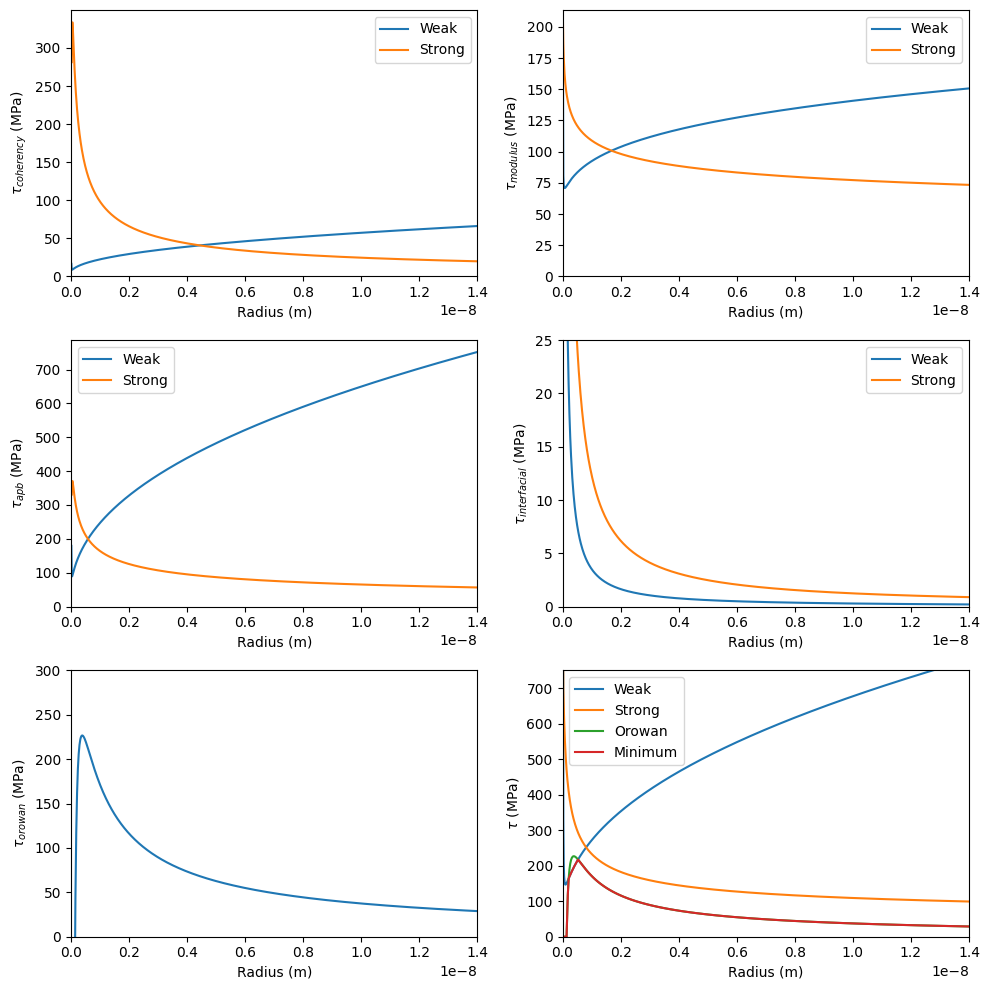

In [4]:
import matplotlib.pyplot as plt
from kawin.precipitation.coupling import OrowanContribution, plotContribution, plotPrecipitateStrength

fig, ax = plt.subplots(3,2,figsize=(10,10))
rss = np.linspace(0, 14e-9, 1000)
ls = rss * (np.sqrt(3*np.pi/4/0.0075) - np.pi/2)

plotContribution(rss, ls, coherency, dislocations, ax=ax[0,0])
plotContribution(rss, ls, modulus, dislocations, ax=ax[0,1])
plotContribution(rss, ls, apb, dislocations, ax=ax[1,0])
plotContribution(rss, ls, interfacial, dislocations, ax=ax[1,1])
plotContribution(rss, ls, OrowanContribution(), dislocations, ax=ax[2,0])
plotPrecipitateStrength(rss, ls, sm, 'AL3SC', True, ax=ax[2,1])
ax[1,1].set_ylim([0, 25])
ax[2,0].set_ylim([0, 300])
ax[2,1].set_ylim([0, 750])
fig.tight_layout()

The strength model can be added as a coupling function to the KWN model. After this, the KWN model can be solved.

In [5]:
from kawin.precipitation import PrecipitateModel

model = PrecipitateModel(matrix, precipitate, therm, 400+273.15)
model.addCouplingModel(sm)
model.solve(250*3600, verbose=True, vIt=5000)

C:\Users\ury3\OneDrive - LLNL\Documents\Projects\U-C Modeling\kawin-development\kawin\kawin\precipitation\NucleationRate.py:190: RuntimeWarning: divide by zero encountered in divide
  incubationTime = np.amin([np.exp(-tau[indices] / time), np.ones(tau[indices].shape)], axis=0)


N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
0	0.0e+00		0.0		673		0.2000

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	AL3SC	0.000e+00		0.0000		0.0000e+00	3.6624e+03

N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
3744	9.0e+05		34.2		673		0.0165

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	AL3SC	7.190e+19		0.7345		2.8049e-08	8.0770e+01



Plotting the strength contributions are done through the StrengthModel object. In plotContributions is set to False, then the overall strength contribution will be plotting. If True, then the strength contributions from the precipitate hardening mechanisms, solid solution strengthening and the base strength will be plotted. Since the solid solution strengthening and base strength was not included in the model, only the precipitate hardening mechanisms contributed to the overall strength.

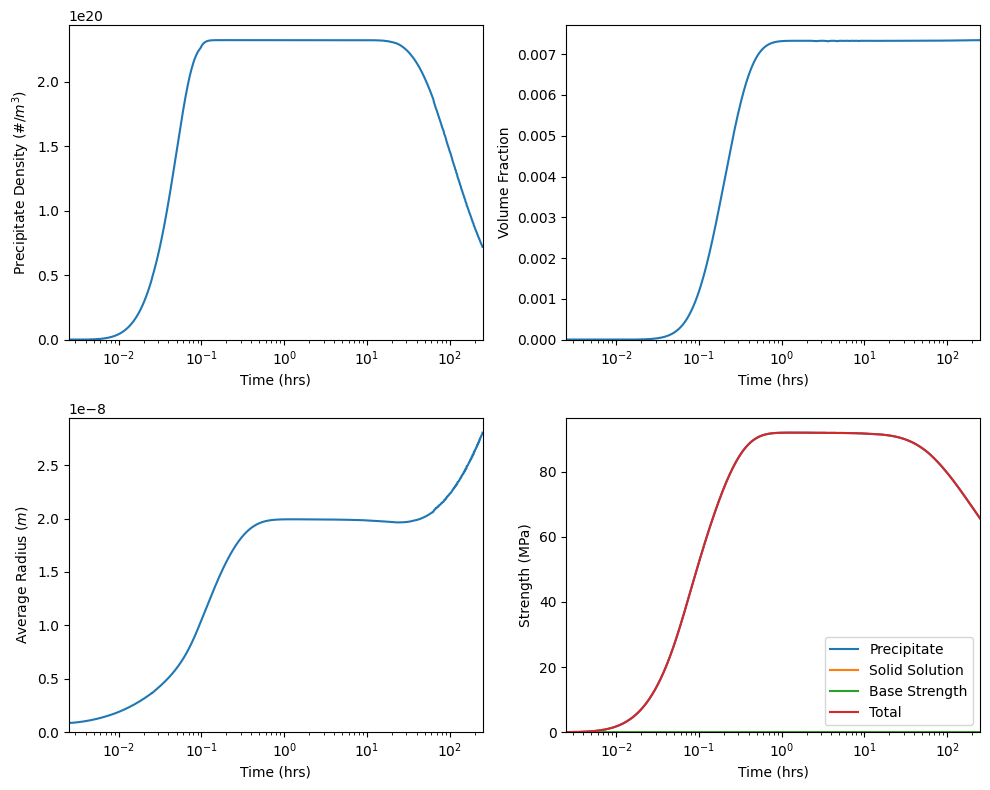

In [6]:
from kawin.precipitation.Plot import plotPrecipitateDensity, plotVolumeFraction, plotAverageRadius
from kawin.precipitation.coupling import plotAlloyStrength

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

plotPrecipitateDensity(model, timeUnits='h', ax=ax[0,0])
plotVolumeFraction(model, timeUnits='h', ax=ax[0,1])
plotAverageRadius(model, timeUnits='h', ax=ax[1,0])
plotAlloyStrength(model, sm, plotContributions=True, timeUnits='h', ax=ax[1,1])

fig.tight_layout()

The individual strengthening mechanisms can be plotted as a function of time as well as the precipitate radius. Rather than including the mean projected radius and inter-particle distance, the solved precipitate model is inserted into the plotting function.

Here, we can see that the interfacial energy had very little contribution to the strength from dislocation cutting compared to the other three mechanisms. However, the strength was mainly governed by Orowan strengthening.

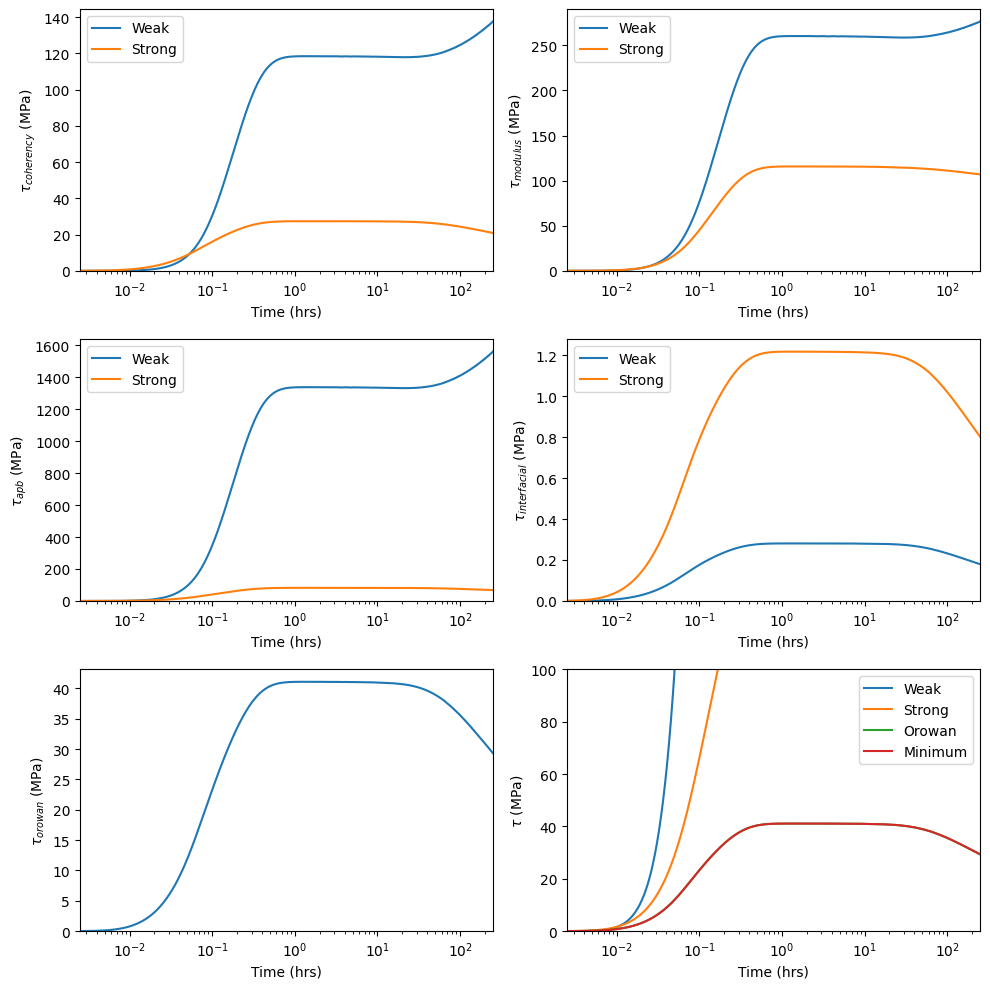

In [7]:
from kawin.precipitation.coupling import plotContributionOverTime, plotPrecipitateStrengthOverTime

fig, ax = plt.subplots(3,2,figsize=(10,10))
plotContributionOverTime(model, sm, coherency, timeUnits='h', ax=ax[0,0])
plotContributionOverTime(model, sm, modulus, timeUnits='h', ax=ax[0,1])
plotContributionOverTime(model, sm, apb, timeUnits='h', ax=ax[1,0])
plotContributionOverTime(model, sm, interfacial, timeUnits='h', ax=ax[1,1])
plotContributionOverTime(model, sm, OrowanContribution(), timeUnits='h', ax=ax[2,0])
plotPrecipitateStrengthOverTime(model, sm, 'AL3SC', True, timeUnits='h', ax=ax[2,1])
ax[2,1].set_ylim([0, 100])
fig.tight_layout()

## References

1. A. T. Dinsdale, "SGTE Data for Pure Elements" *Calphad* 15 (1991) p. 317
2. H. Bo et al, "Experimental study and thermodynamic modeling of the Al-Sc-Zr system" *Computational Materials Science* 133 (2017) p. 82
3. M. R. Ahmadi et al, "A model for precipitate strengthening in multi-particle systems" *Computational Materials Science* 91 (2014) p. 173
4. D. Seidman et al, "Precipitation strengthening at ambient and elevated temperatures of heat-treatable Al(Sc) alloys" *Acta Materialia* 50 (2002) p. 4021
5. K. Deane et al, "Utilization of bayesian optimization and KWN modeling for increased efficiency of Al-Sc precipitation strengthening" *Metals* 12 (2022) p. 975
